# Membrane Test: Investigation through Simulation
**Summary:** This document will generate current transients which simulate those made by neurons in whole-cell patch-clamp configuration (with noise, filtering, etc.) to allow the testing of code to reverse-calculate the starting conditions: membrane resistance ($R_{m}$), membrane capacitance ($C_{m}$), cell charge ($Q$), and the RC time constant of the voltage clamp ($\tau$)

**Important equations:**
* $R_{m} = \Delta V / \Delta I$
* $\tau = R_{m}C_{m} $
* $I = e^{-t/(R_{m}C_{m})}$
* $I = e^{-t/\tau}$

In [1]:
import scipy.signal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

def plt_decorate(title=None, xlabel="signal time (sec)", ylabel="clamp current (pA)", legend=False):
    """draw a title and axis labels on a voltage-clamp plot."""
    if title:
        plt.title(title,fontsize=16)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legend:
        plt.legend()
    plt.margins(0,.1)
    plt.tight_layout()
    
def compare_measurement(measured,actual,feature,units):
    print("  actual %s: %.03f %s"%(feature, actual, units))
    print("measured %s: %.03f %s"%(feature, measured, units))
    print(" difference: %.03f %%"%(measured/actual*100.0-100))
    print()

# Simulating Membrane Tests

This base function creates an ideal membrane test (current recording in response to a voltage step) for a neuron with the given properties. Units will always be in Ohms, Farads, Seconds, and Hertz.

In [2]:
def create_memtest(dV=10*1e-3, Rm=200*1e6, Cm=50*1e-12, Ra=15*1e6, Ih=0*1e-12, 
                   time_sec=.1, sample_rate_hz=20000, showInfo=False):
    """Create a current response to a voltage step using neuron-like electrical properties."""   
    point_count=int(time_sec*sample_rate_hz)
    tau_sec=(Ra*Cm)
    tau_points=sample_rate_hz*tau_sec
    dI = dV/Rm
    I0=dV/Ra
    Xs=np.arange(point_count)
    Ys1=np.ones(point_count)*Ih
    Ys2=np.exp(-Xs/tau_points)*I0+Ih+dI
    trace=np.concatenate((Ys1,Ys2))
    trace=np.concatenate((-trace+Ih*2+dI,trace))
    trace-=dI
    
    if showInfo:
        print("Ih: %.03f pA"%(Ih*1e12))
        print("Rm: %.03f MOhm"%(Rm*1e-6))
        print("Ra: %.03f MOhm"%(Ra*1e-6))
        print("Cm: %.03f pF"%(Cm*1e12))
        print("tau: %.03f ms"%(tau_sec*1e3))
    
    return trace*1e12

## Creating an Ideal Membrane Test

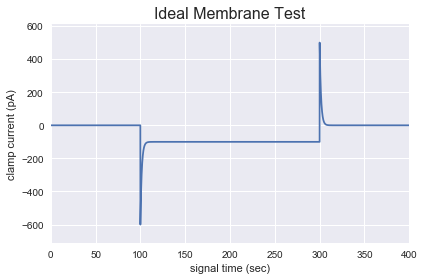

In [3]:
trace_ideal=create_memtest(Rm=100*1e6, Cm=75*1e-12, Ra=20*1e6)
trace_times=np.arange(len(trace_ideal))/20
plt.plot(trace_times,trace_ideal)
plt_decorate("Ideal Membrane Test")

## Simulating Realism with Distortion
This function modifies data to simulate hardware-based low-pass filtering and the addition of amplifier noise.

* amplifier noise is gaussian-weighted (normally distributed)
* If using the bessel filter the data will be _time shifted_ appropraitely (using rolling)

In [4]:
def signal_distort(data, noise_scale=5, bessel_filter_khz=2, sample_rate_hz=20000):
    """Simulate a hardware bessel filter and amplifier noise."""
    if bessel_filter_khz>0:
        filter_order = 4
        B, A = scipy.signal.bessel(filter_order, bessel_filter_khz*1000/sample_rate_hz)
        data = scipy.signal.filtfilt(B, A, data)
        roll_size=1/(bessel_filter_khz*1000/sample_rate_hz)
        data = np.roll(data,int(roll_size))
    if noise_scale>0:
        data = data + np.random.normal(scale=noise_scale,size=len(data))
    return data

### Amplifier Noise
Note that the noise argument is not just random noise - it's Gaussian-weighted (normally distributed) noise values. This is most lifelike.

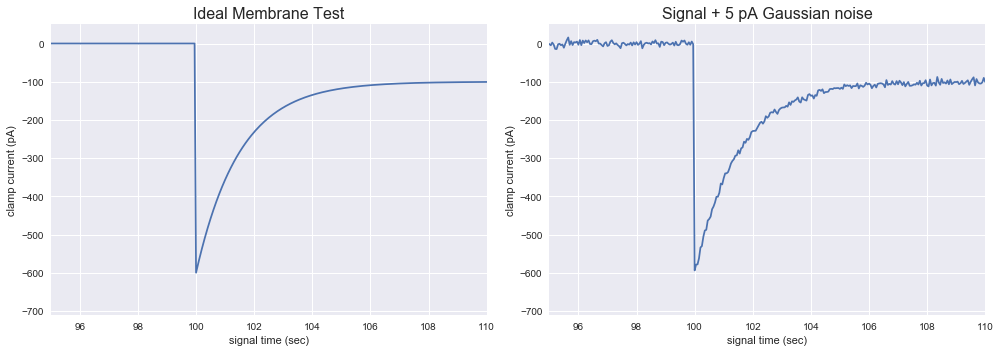

In [5]:
plt.figure(figsize=(14,5))

ax1=plt.subplot(121)
plt_decorate("Ideal Membrane Test")
plt.plot(trace_times,trace_ideal)

plt.subplot(122,sharex=ax1,sharey=ax1)
plt_decorate("Signal + 5 pA Gaussian noise")
plt.plot(trace_times,signal_distort(trace_ideal, noise_scale=5, bessel_filter_khz=0))

plt.axis([95,110,None,50]);

## Hardware Lowpass Filter
According to [the MultiClamp 700B datasheet](https://www.moleculardevices.com/sites/default/files/en/asset/dd/data-sheets/multiclamp-700b-microelectrode-amplifier.pdf), the MultiClamp 700B patch-clamp amplifier has a 4-pole Bessel or Butterworth filter. My laboratory typically uses the Bessel filter, so I have implimented it in software using the `scipy.signals` package.

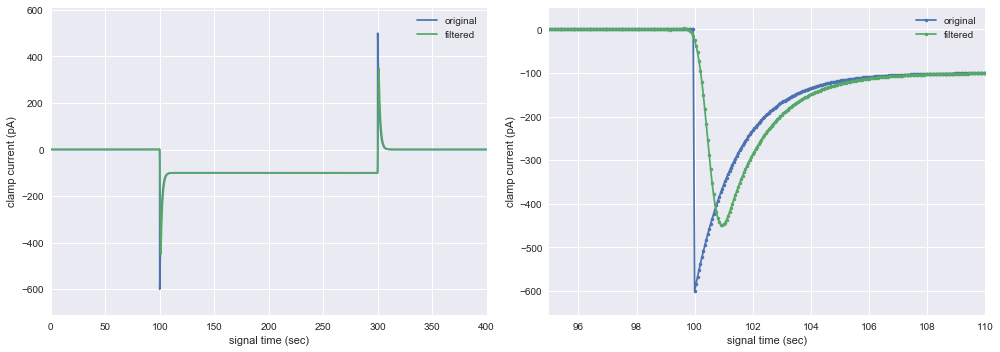

In [6]:
trace_filtered=signal_distort(trace_ideal, noise_scale=0, bessel_filter_khz=2)

plt.figure(figsize=(14,5))

plt.subplot(121)
plt.plot(trace_times,trace_ideal,label="original")
plt.plot(trace_times,trace_filtered,label="filtered")
plt_decorate(legend=True)

plt.subplot(122)
plt.plot(trace_times,trace_ideal,'.-',label="original")
plt.plot(trace_times,trace_filtered,'.-',label="filtered")
plt.axis([95,110,None,50]);
plt_decorate(legend=True)

The result looks more dramatic than it is. In reality, you never notice how "sharp" the theoretical peak of the transient is ($I_{0}$).

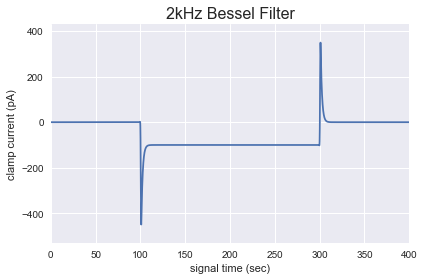

In [7]:
plt.plot(trace_times,trace_filtered)
plt_decorate("2kHz Bessel Filter")

Only plotting the filtered signal, it loosk normal (similar to what you would see in real life).

## Simulate common neuron types

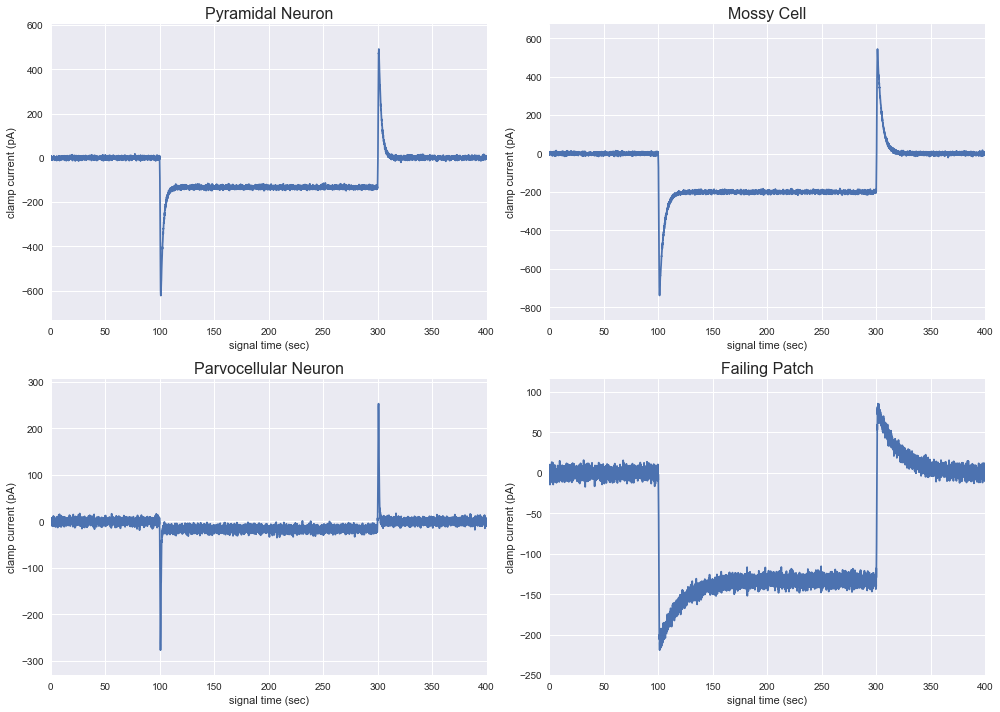

In [8]:
def display_cell(Rm,Cm,Ra=16*1e6,title=None):
    Ys=signal_distort(create_memtest(Rm=Rm,Cm=Cm,Ra=Ra))
    Xs=np.arange(len(Ys))/20
    plt.plot(Xs,Ys)
    plt_decorate(title=title)

plt.figure(figsize=(14,10))
plt.subplot(221)
display_cell(Rm=75*1e6, Cm=150*1e-12, title="Pyramidal Neuron")
plt.subplot(222)
display_cell(Rm=50*1e6, Cm=250*1e-12, title="Mossy Cell")
plt.subplot(223)
display_cell(Rm=600*1e6, Cm=25*1e-12, title="Parvocellular Neuron")
plt.subplot(224)
display_cell(Rm=75*1e6, Cm=150*1e-12, Ra=123*1e6, title="Failing Patch")

---

# Working Backwards: Membrane Properties Analysis
We now have have useful function (`create_memtest`) to generate memtest-like signals. Let's practice analyzing nothing but these signals to see if we can re-derive membrane properties: membrane resistance ($R_{m}$), membrane capacitance ($C_{m}$), cell charge ($Q$), and the RC time constant of the voltage clamp ($\tau$)

## Edit this block to define your model neuron and amplifier

In [9]:
# Cell properties
real_Rm=75*1e6
real_Ra=25*1e6
real_Cm=150*1e-12
real_Ih=-80*1e-12

# Amplifier properties
filter_khz=2 # set to 0 to disable filter

In [10]:
signal_ideal=create_memtest(Rm=real_Rm, Cm=real_Cm, Ih=real_Ih, Ra=real_Ra, showInfo=True)
trace_full=signal_distort(signal_ideal, bessel_filter_khz=filter_khz)
trace_times=np.arange(len(trace_full))/20000

Ih: -80.000 pA
Rm: 75.000 MOhm
Ra: 25.000 MOhm
Cm: 150.000 pF
tau: 3.750 ms


_our goal will be to re-derive these values using only the signal trace_

## Measuring Current over a Range

The calculation of ($I_{h}$) and ($R_{m}$) depends on our ability to calculate an average current over a range of time. While a complex method could be used (such as binning data points into a histogram, fitting a Gaussian curve to the histogram counts, and using the current measurement corresponding to the peak of the curve), for now we can simply take the average of a range.

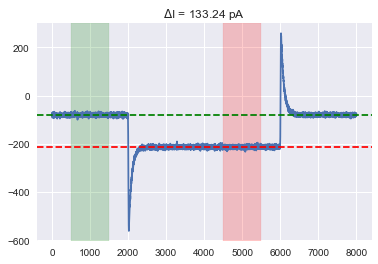

In [11]:
plt.plot(trace_full)
plt.axvspan(500,1500,color='g',alpha=.2)
plt.axvspan(4500,5500,color='r',alpha=.2)

I1=np.average(trace_full[500:1500])
I2=np.average(trace_full[4500:5500])

plt.axhline(I1,color='g',ls='--')
plt.axhline(I2,color='r',ls='--')
plt.title("$\Delta$I = %.02f pA"%(np.abs(I1-I2)));

## Calculate $I_{h}$
$I_{h}$ is just the average of the first shaded area

In [12]:
Ih = I1*1e-12
compare_measurement(Ih*1e12,real_Ih*1e12,"Ih","pA")

  actual Ih: -80.000 pA
measured Ih: -80.060 pA
 difference: 0.075 %



## Calculate $R_{m}$
$R_{m}$ is the ratio of the two shaded areas, $R_{m} = \Delta V / \Delta I$

In [13]:
dI = np.abs(I1-I2)*1e-12
dV = 10*1e-3
Rm = dV/dI
compare_measurement(Rm*1e-6,real_Rm*1e-6,"Rm","MOhm")

  actual Rm: 75.000 MOhm
measured Rm: 75.050 MOhm
 difference: 0.066 %



## Breaking Data into Sections
When looking at the membrane tests above, it will be useful to study only one "section" at a time.

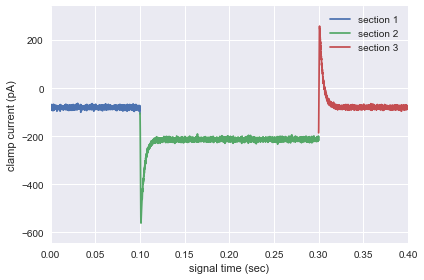

In [14]:
trace1=trace_full[:2000]
trace1x=trace_times[:2000]

trace2=trace_full[2000:6000]
trace2x=trace_times[2000:6000]

trace3=trace_full[6000:]
trace3x=trace_times[6000:]

plt.plot(trace1x,trace1,label="section 1")
plt.plot(trace2x,trace2,label="section 2")
plt.plot(trace3x,trace3,label="section 3")
plt_decorate(legend=True)

## Isolate a transient to study in detail
The time axis no longer matters (as long as we know the sample rate). Subtract-out Ih so it's centered at 0.

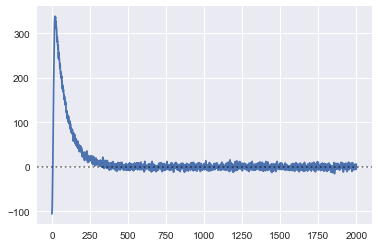

In [15]:
originalCurve=trace3-Ih*1e12
plt.plot(originalCurve);
plt.axhline(0,color='k',alpha=.5,ls=":");

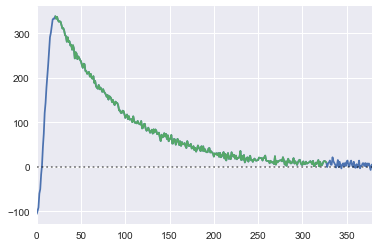

In [16]:
peakI=np.where(originalCurve==np.max(originalCurve))[0][0]
zeroI=np.where(originalCurve[peakI:]<=0)[0][0]+peakI

fitThis=originalCurve[peakI:zeroI]
fitThisXs=np.arange(len(fitThis))/20000

plt.plot(np.arange(len(originalCurve)),originalCurve);
plt.plot(np.arange(len(fitThis))+peakI,fitThis);
plt.axhline(0,color='k',alpha=.5,ls=":");
plt.axis([0,zeroI+50,None,None]);

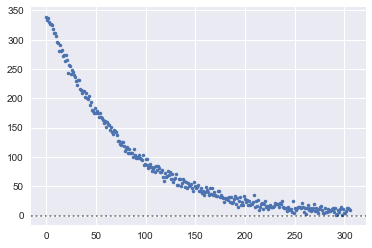

In [17]:
plt.plot(fitThis,'.');
plt.axhline(0,color='k',alpha=.5,ls=":");

## Study the Monoexponnential Curve to Yield $R_{a}$, $I_{0}$, $C_{m}$, and $\tau$

There are a few different ways to do this. Let's try them out! Our starting point is the `fitThis` data graphed above.

### Method 1: Calculate $\tau$ by Fitting the Curve with SciPy
If you're okay with committing yourself to using scipy (which can be a pain to install on some systems), you can fit the curve and calculate $\tau$ like this:

  actual tau: 3.750 ms
measured tau: 3.762 ms
 difference: 0.312 %

  actual I0: 400.000 pA
measured I0: 456.412 pA
 difference: 14.103 %

  actual Ia: 25.000 MOhm
measured Ia: 21.910 MOhm
 difference: -12.360 %

  actual Cm: 150.000 pF
measured Cm: 171.689 pF
 difference: 14.459 %



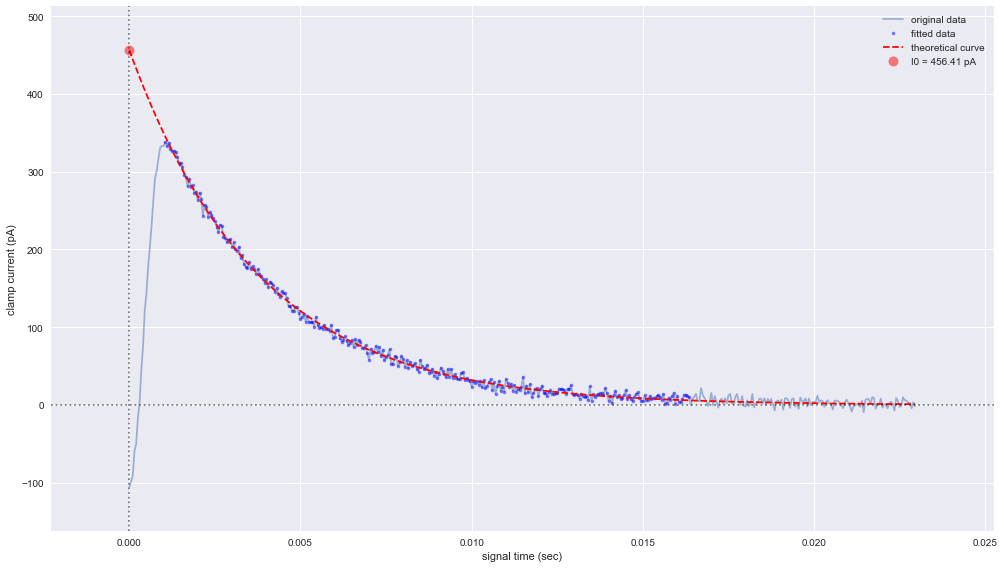

In [18]:
import scipy.optimize

def monoExp(x, m, t):
    return m*np.exp(-t*x)

# fit the curve to find tau
params, cv = scipy.optimize.curve_fit(monoExp, fitThisXs, fitThis, p0=(1,1e-6))
m,t=params
tau=1/t
real_tau=(real_Ra*real_Cm)
compare_measurement(tau*1e3,real_tau*1e3,"tau","ms")

# use tau to create a theroetical curve, extrapolating back to I0
offsetX=fitThisXs[peakI]
fittedXs=(np.arange(int(len(fitThis)*1.5))-peakI)/20000
fittedCurve=monoExp(fittedXs,m,t)

# read I0 from the extrapolated fitted curve
I0=fittedCurve[0]*1e-12
real_I0=dV/real_Ra
compare_measurement(I0*1e12,real_I0*1e12,"I0","pA")

# calculate Ra=dV/I0
Ra=dV/I0
compare_measurement(Ra*1e-6,real_Ra*1e-6,"Ia","MOhm")

# calculate Cm=tau/Ra
Cm=tau/Ra
compare_measurement(Cm*1e12,real_Cm*1e12,"Cm","pF")

# show what we learned
plt.figure(figsize=(14,8))
plt.plot(fittedXs+offsetX,originalCurve[:len(fittedXs)],alpha=.5,label="original data")
plt.plot(fitThisXs+offsetX,fitThis,'b.',alpha=.5,label="fitted data")
plt.plot(fittedXs+offsetX,fittedCurve,'--',color='r',label="theoretical curve")
plt.plot(0,I0*1e12,'.',ms=20,alpha=.5,color='r',label="I0 = %.02f pA"%(I0*1e12))
plt.axhline(0,color='k',alpha=.5,ls=":");
plt.axvline(0,color='k',alpha=.5,ls=":");
plt_decorate(legend=True)
plt.margins(.1,.1)

Tau is EXTREMELY sensitive to the low-pass filter. We will investigate this futher later. If you turn the hardware filter off (by setting its khz to 0)

### Method 2: guess $\tau$ by successive approximation

This is a simple method to calculate $\tau$ which is extremely fast and doesn't require any special libraries.

Let's remind ourselves of our starting point:

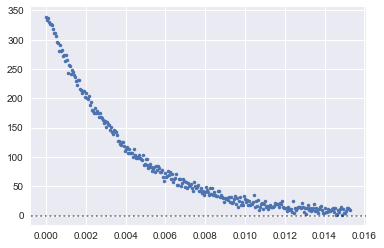

In [19]:
plt.plot(fitThisXs,fitThis,'.');
plt.axhline(0,color='k',alpha=.5,ls=":");

Consider the formula we used earlier for the monoexponential function:

$ I_{x} = m*exp(-x/\tau) + b $

If we assume that our "tail" approaches 0 (which we did by subtracting-out the steady-state current), we can eliminate $b$:

$ I_{x} = m*exp(-x/\tau)$

Now if we normalize the data (so the first point is 1), we can get rid of $m$:

$ I_{x} = exp(-x/\tau)$

Suddenly this formula became very easy to fit!

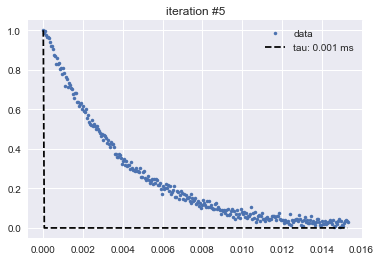

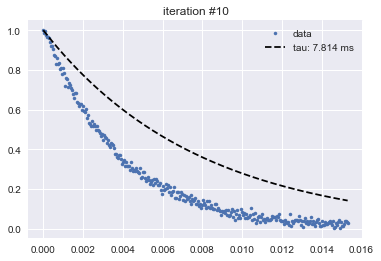

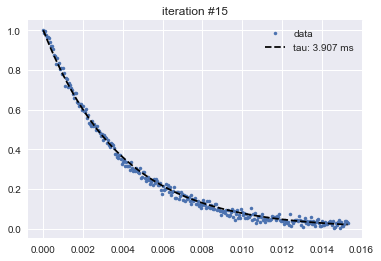

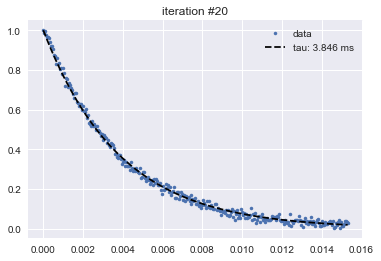

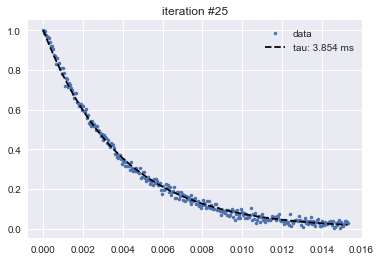

Tau: 3.854 ms


In [20]:
def monoExp1d(Xs, tau):
    return np.exp(-Xs/tau)

def monoExp1dErr(Xs, data, tau, plotTitle=False):
    """return the summed difference (error) of the data from the real curve."""    
    fitted=monoExp1d(fitThisXs,tau)
    err=np.sum(fitted-data)    
    if plotTitle:
        plt.plot(fitThisXs,data,'.',label="data");
        plt.plot(fitThisXs,fitted,'k--',label="tau: %.03f ms"%(tau*1e3));
        plt.legend()
        plt.title(plotTitle)
        plt.show()    
    return err

def bestTau(Xs, data, tau=.1, step=.5):
    """Returns time constant of the data in the same time units as the Xs (list of time points) provided."""
    errs=[np.inf]
    normed=data/data[0]
    while(len(errs))<50:
        assert len(Xs)==len(data)
        normed=fitThis/fitThis[0]
        tau=np.max((0.000001,tau))
        if len(errs)%5==0:
            errs.append(monoExp1dErr(Xs,normed,tau,plotTitle="iteration #%d"%len(errs)))
        else:
            errs.append(monoExp1dErr(Xs,normed,tau))
        if np.abs(errs[-1])<0.01:
            return tau
        if (errs[-1]>0 and errs[-2]<0) or (errs[-1]<0 and errs[-2]>0):
            step/=2
        if errs[-1]<0:
            tau+=step
        elif errs[-1]>0:
            tau-=step
    return tau

tau=bestTau(fitThisXs,fitThis)
print("Tau: %.03f ms"%(tau*1e3))

You'll notice we have discovered the same tau! We can calculate the rest easily.

In [21]:
# use tau to create a theroetical curve, extrapolating back to I0
offsetX=fitThisXs[peakI]
fittedXs=(np.arange(int(len(fitThis)*1.5))-peakI)/20000
fittedCurve=monoExp1d(fittedXs,tau)*fitThis[0]

# read I0 from the extrapolated fitted curve
I0=fittedCurve[0]*1e-12
real_I0=dV/real_Ra
compare_measurement(I0*1e12,real_I0*1e12,"I0","pA")

# calculate Ra=dV/I0
Ra=dV/I0
compare_measurement(Ra*1e-6,real_Ra*1e-6,"Ra","MOhm")

# calculate Cm=tau/Ra
Cm=tau/Ra
compare_measurement(Cm*1e12,real_Cm*1e12,"Cm","pF")

  actual I0: 400.000 pA
measured I0: 444.337 pA
 difference: 11.084 %

  actual Ra: 25.000 MOhm
measured Ra: 22.505 MOhm
 difference: -9.978 %

  actual Cm: 150.000 pF
measured Cm: 171.241 pF
 difference: 14.160 %



We got all the same values, and never had to do a multi-dimensional curve fit.

# Putting it All Together
Let's simplify all these steps by making a single function to return memtest values from original data. We can then start testing how different factors affect the accuracy of different membrane test features. This code block is all it takes to calculate $I_{h}$, $R_{m}$, $R_{a}$, $C{m}$, $\tau$, and $I_{0}$:

In [22]:
def monoExpTau(data,sample_rate_hz=20000,tau=.1,step=.1):
    """Given some data which decays to zero, return its time constant (found by successive approximation)."""
    if len(data)==0:
        return np.nan
    errs=[np.inf]
    normed=data/data[0]
    Xs=np.arange(len(normed))/sample_rate_hz
    while(len(errs))<50:
        assert len(Xs)==len(data)
        tau=np.max((0.000001,tau))
        errs.append(np.sum(np.exp(-Xs/tau)-normed))
        if np.abs(errs[-1])<0.01:
            return tau
        if (errs[-1]>0 and errs[-2]<0) or (errs[-1]<0 and errs[-2]>0):
            step/=2
        if errs[-1]<0:
            tau+=step
        elif errs[-1]>0:
            tau-=step
    return tau

def memtest(trace1, trace2, rate_hz=20000, dV=10*1e-3,avgLastFrac=.75):
    """
    Given data (pA) immediately after a voltage step, return all membrane test features.
    sig1 and sig2 are the downward/upward currents in response to the voltage step.
    """
    
    # this memtest dictionary is what gets returned
    mt_dict={"dV":dV*1e3}
    
    # subtract-out the steady state current so signals are centered at 0
    Ih1=np.average(trace1[int(avgLastFrac*len(trace1)):])
    Ih2=np.average(trace2[int(avgLastFrac*len(trace2)):])
    data1=trace1-Ih1
    data2=trace2-Ih2
    
    # Rm - compare the steady state currents to calculate membrane resistance
    dI = (np.abs(Ih2-Ih1)*1e-12)
    Rm = dV/dI # Rm = dV/dI
    mt_dict["Rm"]=Rm*1e-6
    
    # let's improve out data by averaging the two curves together
    point_count=np.min((len(trace1),len(trace2)))
    data=np.average((-data1[:point_count],data2[:point_count]),axis=0)
    
    # Find the points of the trace we intend to fit
    peakI=np.where(data==np.max(data))[0][0]
    zeroI=np.where(data[peakI:]<=0)[0]
    if len(zeroI)==0:
        zeroI=peakI
    else:
        zeroI=zeroI[0]+peakI
    
    # Fit the curve to a monoexponential equation and record tau
    tau=monoExpTau(data[peakI:zeroI])
    mt_dict["tau"]=tau*1e3

    # use tau to guess what I0 probably was at the first point after the step
    I0=np.exp((peakI/rate_hz)/tau)*data[peakI]*1e-12
    mt_dict["I0"]=I0*1e12
    
    # calculate Ra=dV/I0
    Ra=dV/I0
    mt_dict["Ra"]=Ra*1e-6

    # calculate Cm=tau/Ra
    Cm=tau/Ra
    mt_dict["Cm"]=Cm*1e12    
    
    return mt_dict
    
def memtest_display(mt_dict):
    """Given a memtest dictionary, show the important stuff with its units."""
    print("Rm: %.02f MOhm"%(mt_dict["Rm"]))
    print("Ra: %.02f MOhm"%(mt_dict["Ra"]))
    print("Cm: %.02f pF"%(mt_dict["Cm"]))
    print("tau: %.03f ms"%(mt_dict["tau"]))

## Trying it out
Let's assume our membrane tests occur by a brief step down -10 mV then back up. As such, we will always produce two "pieces" of current data which the memtest function can use to calculate all the membrane properties. As a reminder, this data is in `trace2` and `trace3`. It is the user's responsibility to separate these before using the memtest function. From there, just feed the pieces to `memtest()`:

Rm: 75.27 MOhm
Ra: 21.98 MOhm
Cm: 172.46 pF
tau: 3.791 ms


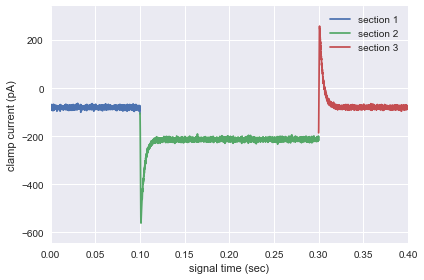

In [24]:
plt.plot(trace1x,trace1,label="section 1")
plt.plot(trace2x,trace2,label="section 2")
plt.plot(trace3x,trace3,label="section 3")
plt_decorate(legend=True)

mt_dict=memtest(trace2, trace3)
memtest_display(mt_dict)